## Running this notebook

You can launch this notebook using mybinder by clicking the button below.

<a href="https://mybinder.org/v2/gh/US-GHG-Center/ghgc-docs/HEAD?labpath=user_data_notebooks/nasa_ceos_co2_flux.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the OCO-2 GEOS Assimilated CO2 Concentrations data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.

   

## About the Data

In July 2014, NASA successfully launched the first dedicated Earth remote sensing satellite to study atmospheric carbon dioxide (CO₂) from space. The Orbiting Carbon Observatory-2 (OCO-2) is an exploratory science mission designed to collect space-based global measurements of atmospheric CO₂ with the precision, resolution, and coverage needed to characterize sources and sinks (fluxes) on regional scales (≥1000 km). This dataset provides global gridded, daily column-averaged carbon dioxide (XCO₂) concentrations from January 1, 2015 - February 28, 2022. The data are derived from OCO-2 observations that were input to the Goddard Earth Observing System (GEOS) Constituent Data Assimilation System (CoDAS), a modeling and data assimilation system maintained by NASA’s Global Modeling and Assimilation Office (GMAO). Concentrations are measured in moles of carbon dioxide per mole of dry air (mol CO₂/mol dry) at a spatial resolution of 0.5° x 0.625°. Data assimilation synthesizes simulations and observations, adjusting modeled atmospheric constituents like CO₂ to reflect observed values. With the support of NASA’s Carbon Monitoring System (CMS) Program and the OCO Science Team, this dataset was produced as part of the OCO-2 mission which provides the highest quality space-based XCO₂ retrievals to date.

# Installing the Required Libraries
Please run the next cell to install all the required libraries to run the notebook.

In [1]:
%pip install requests
%pip install folium
%pip install rasterstats
%pip install pystac_client

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

## Querying the STAC API

In [3]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.
# Name of the collection for OCO-2 GEOS Assimilated CO2 Concentrations. 
collection_name = "oco2geos-co2-daygrid-v10r"

In [4]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'oco2geos-co2-daygrid-v10r',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/oco2geos-co2-daygrid-v10r/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/oco2geos-co2-daygrid-v10r'}],
 'title': 'OCO-2 GEOS Assimilated CO2 Concentrations',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180.3125, -90.25, 179.6875, 90.25]]},
  'temporal': {'interval': [['2015-01-01T00:00:00+00:00',
     '2022-02-28T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': None,
 'summaries': {'datetim

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2015 to February 2022. By looking at the `dashboard:time density`, we can see that these observations are collected daily.

In [5]:
# Check total number of items available
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=500").json()["features"]
print(f"Found {len(items)} items")

Found 500 items


In [6]:
# Examining the first item in the collection
items[0]

{'id': 'oco2geos-co2-daygrid-v10r-20220228',
 'bbox': [-180.3125, -90.25, 179.6875, 90.25],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/oco2geos-co2-daygrid-v10r'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/oco2geos-co2-daygrid-v10r'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220228'}],
 'assets': {'xco2': {'href': 's3://ghgc-data-store/oco2geos-co2-daygrid-v10r/oco2_GEOS_XCO2_L3CO2_day_B10206Ar_20220228.tif',
   'type': 'image/tiff; application=geotiff',
   'roles': ['data', 'laye

Below, we enter minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in Column-Averaged XCO₂ Concentrations Levels Using the Raster API

In this notebook, we will explore the temporal impacts of CO₂ emissions. We will visualize the outputs on a map using `folium.`

In [7]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item["properties"]["datetime"]: item for item in items} 
asset_name = "xco2" #fossil fuel

In [8]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

KeyError: 'raster:bands'

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for 2022-02-08 and again for 2022-01-27, so that we can visualize each event independently.

In [ ]:
color_map = "magma"
oco2_1 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[0]]['collection']}&item={items[list(items.keys())[0]]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
oco2_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=oco2geos-co2-daygrid-v10r&item=oco2geos-co2-daygrid-v10r-20220208&assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0004114723196835257%2C0.00042379616934340447'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

In [ ]:
oco2_2 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[1]]['collection']}&item={items[list(items.keys())[1]]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
oco2_2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=oco2geos-co2-daygrid-v10r&item=oco2geos-co2-daygrid-v10r-20220127&assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0004114723196835257%2C0.00042379616934340447'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

## Visualizing Daily Column-Averaged XCO₂ Concentrations

In [ ]:
# We will import folium to map and folium.plugins to allow mapping side-by-side
import folium
import folium.plugins

# Set initial zoom and center of map for XCO₂ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


map_layer_2020 = TileLayer(
    tiles=oco2_1["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2020.add_to(map_.m1)

map_layer_2019 = TileLayer(
    tiles=oco2_2["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2019.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [ ]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [ ]:
# We will plug in the coordinates for a location inside the the polygon and a zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [ ]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 340 items


In [ ]:
# Explore the first item
items[0]

{'id': 'oco2geos-co2-daygrid-v10r-20220208',
 'bbox': [-180.3125, -90.25, 179.6875, 90.25],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/oco2geos-co2-daygrid-v10r'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/oco2geos-co2-daygrid-v10r'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/oco2geos-co2-daygrid-v10r/items/oco2geos-co2-daygrid-v10r-20220208'}],
 'assets': {'xco2': {'href': 's3://ghgc-data-store-dev/geos-oco2/oco2_GEOS_XCO2_L3CO2_day_B10206Ar_20220208.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': [

In [ ]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "datetime": item["properties"]["datetime"],
    }

In [ ]:
for item in items:
    print(item["properties"]["datetime"])
    break

2022-02-08T00:00:00Z


With the function above we can generate the statistics for the AOI.

In [ ]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]], 'type': 'Polygon'}, 'properties': {'statistics': {'b1': {'min': 0.0004179585594101809, 'max': 0.00041918420902220527, 'mean': 0.0004186627241380142, 'count': 98.0, 'sum': 0.04102894696552539, 'std': 3.0152396668289554e-07, 'median': 0.00041863096703309566, 'majority': 0.0004179585594101809, 'minority': 0.0004179585594101809, 'unique': 98.0, 'histogram': [[2.0, 4.0, 8.0, 9.0, 17.0, 15.0, 11.0, 7.0, 14.0, 11.0], [0.0004179585594101809, 0.00041808112437138336, 0.00041820368933258577, 0.0004183262542937882, 0.00041844881925499065, 0.0004185713842161931, 0.0004186939491773955, 0.00041881651413859793, 0.0004189390790998004, 0.00041906164406100286, 0.00041918420902220527]], 'valid_percent': 87.5, 'masked_pixels': 14.0, 'valid_pixels': 98.0, 'percentile_98': 0.0004191339639510261, 'percentile_2': 0.00041807818401139223}}}}
{'type': 'Feature', 'geometry': {'coordinate

In [ ]:
stats[0]

{'statistics': {'b1': {'min': 0.0004179585594101809,
   'max': 0.00041918420902220527,
   'mean': 0.0004186627241380142,
   'count': 98.0,
   'sum': 0.04102894696552539,
   'std': 3.0152396668289554e-07,
   'median': 0.00041863096703309566,
   'majority': 0.0004179585594101809,
   'minority': 0.0004179585594101809,
   'unique': 98.0,
   'histogram': [[2.0, 4.0, 8.0, 9.0, 17.0, 15.0, 11.0, 7.0, 14.0, 11.0],
    [0.0004179585594101809,
     0.00041808112437138336,
     0.00041820368933258577,
     0.0004183262542937882,
     0.00041844881925499065,
     0.0004185713842161931,
     0.0004186939491773955,
     0.00041881651413859793,
     0.0004189390790998004,
     0.00041906164406100286,
     0.00041918420902220527]],
   'valid_percent': 87.5,
   'masked_pixels': 14.0,
   'valid_pixels': 98.0,
   'percentile_98': 0.0004191339639510261,
   'percentile_2': 0.00041807818401139223}},
 'datetime': '2022-02-08T00:00:00Z'}

In [ ]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_98,percentile_2,date
0,2022-02-08T00:00:00Z,0.000418,0.000419,0.000419,98.0,0.041029,3.015240e-07,0.000419,0.000418,0.000418,98.0,"[[2.0, 4.0, 8.0, 9.0, 17.0, 15.0, 11.0, 7.0, 1...",87.5,14.0,98.0,0.000419,0.000418,2022-02-08 00:00:00+00:00
1,2022-01-27T00:00:00Z,0.000417,0.000419,0.000419,98.0,0.041035,4.051952e-07,0.000419,0.000417,0.000417,98.0,"[[2.0, 4.0, 2.0, 4.0, 7.0, 9.0, 19.0, 22.0, 19...",87.5,14.0,98.0,0.000419,0.000418,2022-01-27 00:00:00+00:00
2,2022-01-20T00:00:00Z,0.000417,0.000419,0.000418,98.0,0.040990,4.180730e-07,0.000418,0.000417,0.000417,98.0,"[[2.0, 4.0, 3.0, 7.0, 28.0, 14.0, 10.0, 7.0, 1...",87.5,14.0,98.0,0.000419,0.000417,2022-01-20 00:00:00+00:00
3,2022-01-16T00:00:00Z,0.000417,0.000420,0.000419,98.0,0.041024,8.535970e-07,0.000418,0.000417,0.000417,98.0,"[[9.0, 22.0, 14.0, 5.0, 3.0, 6.0, 4.0, 10.0, 1...",87.5,14.0,98.0,0.000420,0.000417,2022-01-16 00:00:00+00:00
4,2022-01-11T00:00:00Z,0.000417,0.000418,0.000418,98.0,0.040938,1.907218e-07,0.000418,0.000417,0.000417,98.0,"[[3.0, 3.0, 5.0, 7.0, 10.0, 20.0, 18.0, 22.0, ...",87.5,14.0,98.0,0.000418,0.000417,2022-01-11 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the XCO₂ concentrations time series (January 1, 2015 - February 28, 2022) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CO2 emission Values for Texas, Dallas (2015-2020)')

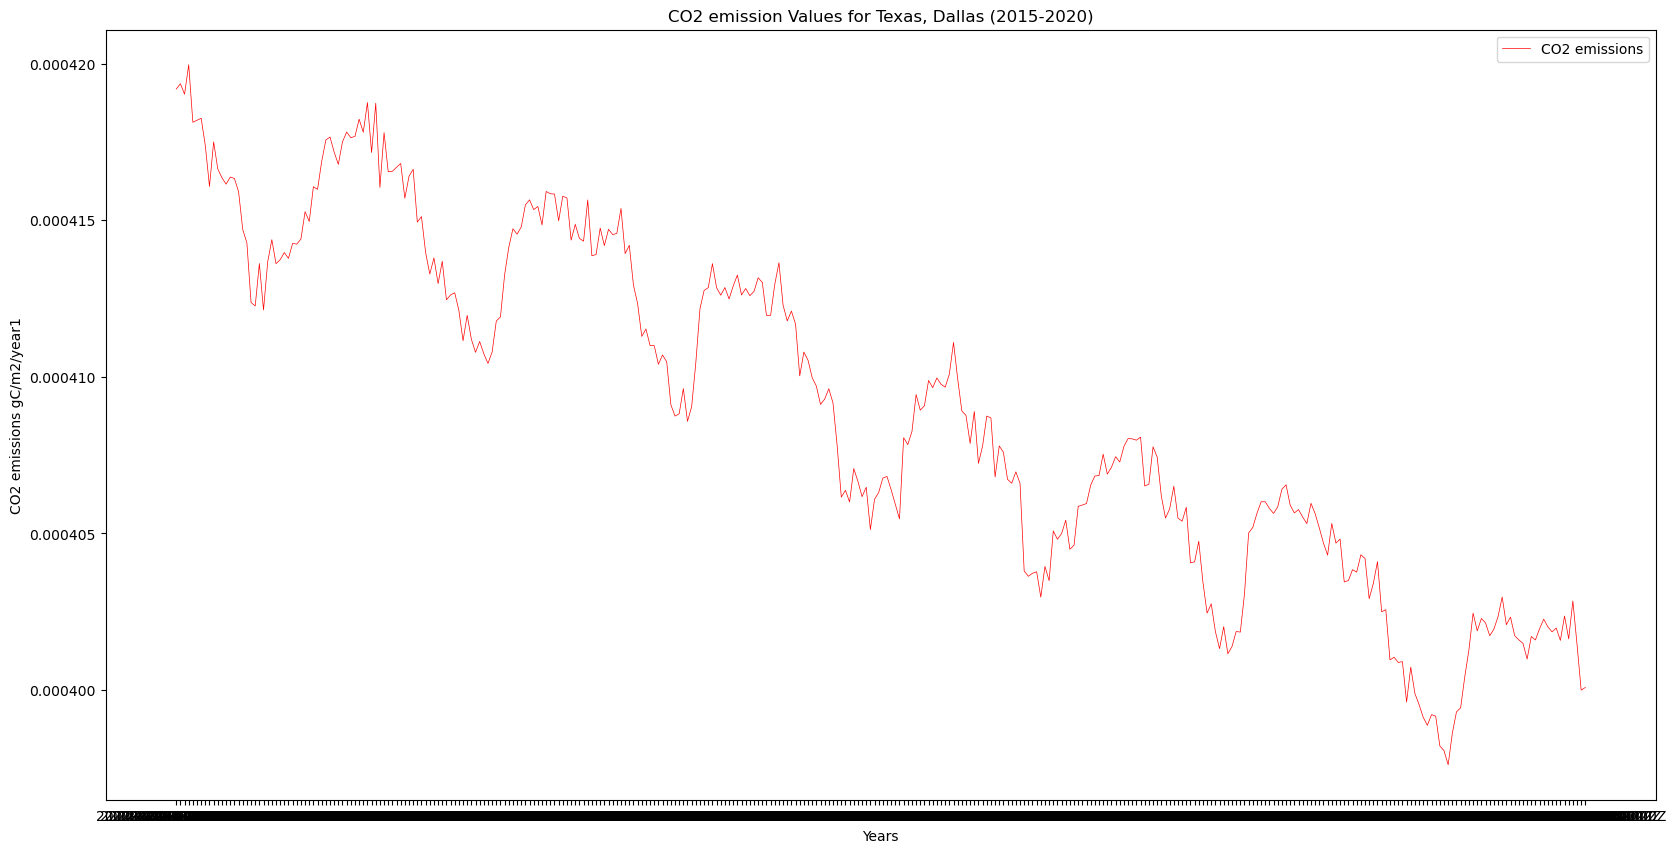

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["datetime"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="XCO₂ concentrations",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO2 emissions mol CO₂/mol dry air")
plt.title("XCO₂ concentrations Values for Texas, Dallas (Jan 2015- Feb 2022)")

In [ ]:
print(items[2]["properties"]["datetime"])

2022-01-20T00:00:00Z


In [ ]:
oco2_3 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
oco2_3

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=oco2geos-co2-daygrid-v10r&item=oco2geos-co2-daygrid-v10r-20220120&assets=xco2&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0004114723196835257%2C0.00042379616934340447'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.3125, -90.25, 179.6875, 90.25],
 'center': [-0.3125, 0.0, 0]}

In [ ]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6.8,
)

map_layer = TileLayer(
    tiles=oco2_3["tiles"][0],
    attr="GHG", opacity = 0.7
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook, we have successfully explored, analyzed, and visualized the STAC collection for OCO-2 GEOS Assimilated CO₂ Concentrations.